In [29]:
import pandas as pd

In [30]:
import pickle

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error

In [46]:
import mlflow

In [51]:
mlflow.set_tracking_uri(uri="http://localhost:5000")

In [52]:
mlflow.set_experiment(experiment_name="nyc-taxi")

2024/11/02 20:14:29 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1730589269737, experiment_id='1', last_update_time=1730589269737, lifecycle_stage='active', name='nyc-taxi', tags={}>

In [33]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [34]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

np.float64(9.838799799829628)

/tmp/ipykernel_5005/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_5005/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


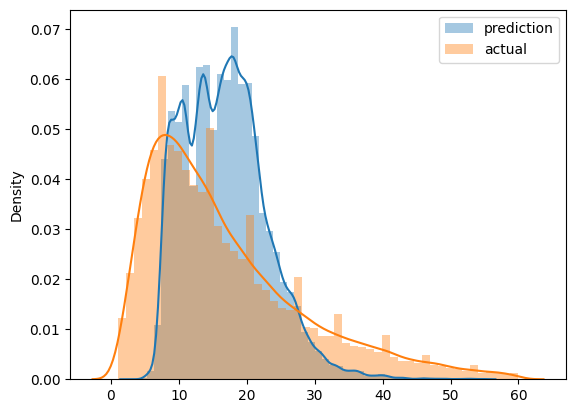

In [35]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [36]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [37]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [38]:
len(df_train), len(df_val)

(73908, 61921)

In [39]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [40]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [41]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

np.float64(7.758715205596356)

In [43]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [57]:
with mlflow.start_run():
    mlflow.set_tag('model', 'linear')
    mlflow.set_tag('developer','luis estevam')
    
    mlflow.log_param("train_data_path", './data/green_tripdata_2021-01.parquet')
    mlflow.log_param("val_data_path", './data/green_tripdata_2021-02.parquet')
    
    params = {
        'alpha': 0.1,
        'random_state': 0
    }
    
    mlflow.log_params(params)
    
    lr = Lasso(**params)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)
    
    mlflow.sklearn.log_model(lr, 'lasso')    

2024/11/02 21:08:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/02 21:08:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-wolf-656 at: http://localhost:5000/#/experiments/1/runs/0112792019a343b89c6918fb10c4396b.
2024/11/02 21:08:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


In [62]:
import xgboost as xgb

from hyperopt import  hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

In [63]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [66]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=20,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [67]:
search_space = {
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
    "device": "cuda",
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72804                          
[1]	validation-rmse:11.28180                          
[2]	validation-rmse:10.87113                          
[3]	validation-rmse:10.49482                          
[4]	validation-rmse:10.14878                          
[5]	validation-rmse:9.83272                           
[6]	validation-rmse:9.54389                           
[7]	validation-rmse:9.28038                           
[8]	validation-rmse:9.04008                           
[9]	validation-rmse:8.82175                           
[10]	validation-rmse:8.62309                          
[11]	validation-rmse:8.44225                          
[12]	validation-rmse:8.27876                          
[13]	validation-rmse:8.13061                          
[14]	validation-rmse:7.99743                          
[15]	validation-rmse:7.87655                          
[16]	validation-rmse:7.76669                          
[17]	validation-rmse:7.66852                          
[18]	valid

2024/11/02 21:20:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-bug-908 at: http://localhost:5000/#/experiments/1/runs/f6ae41f3cccb411f9f7e814feedfe64d.

2024/11/02 21:20:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:9.07708                                                    
  2%|▏         | 1/50 [00:01<01:20,  1.64s/trial, best loss: 7.498834702391793]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.70165                                                    
[2]	validation-rmse:7.14170                                                    
[3]	validation-rmse:6.91566                                                    
[4]	validation-rmse:6.81721                                                    
[5]	validation-rmse:6.76771                                                    
[6]	validation-rmse:6.74583                                                    
[7]	validation-rmse:6.73137                                                    
[8]	validation-rmse:6.72308                                                    
[9]	validation-rmse:6.71846                                                    
[10]	validation-rmse:6.71429                                                   
[11]	validation-rmse:6.70831                                                   
[12]	validation-rmse:6.70622                                                   
[13]	validation-rmse:6.70274            

2024/11/02 21:20:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-shark-724 at: http://localhost:5000/#/experiments/1/runs/ea06468ba606446bb55550f335f9ae4b.

2024/11/02 21:20:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.80266                                                   
[1]	validation-rmse:11.41978                                                   
  4%|▍         | 2/50 [00:02<00:52,  1.10s/trial, best loss: 6.686861398231445]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.06265                                                   
[3]	validation-rmse:10.73022                                                   
[4]	validation-rmse:10.42056                                                   
[5]	validation-rmse:10.13398                                                   
[6]	validation-rmse:9.86722                                                    
[7]	validation-rmse:9.62060                                                    
[8]	validation-rmse:9.39100                                                    
[9]	validation-rmse:9.17905                                                    
[10]	validation-rmse:8.98279                                                   
[11]	validation-rmse:8.80206                                                   
[12]	validation-rmse:8.63549                                                   
[13]	validation-rmse:8.48154                                                   
[14]	validation-rmse:8.33960            

2024/11/02 21:20:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run skillful-goose-181 at: http://localhost:5000/#/experiments/1/runs/b4a0e574dfaf4239a7e25ce32e1c0d57.

2024/11/02 21:20:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.81786                                                   
[1]	validation-rmse:11.44851                                                   
  6%|▌         | 3/50 [00:03<00:55,  1.18s/trial, best loss: 6.686861398231445]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.10275                                                   
[3]	validation-rmse:10.78030                                                   
[4]	validation-rmse:10.47913                                                   
[5]	validation-rmse:10.19866                                                   
[6]	validation-rmse:9.93698                                                    
[7]	validation-rmse:9.69393                                                    
[8]	validation-rmse:9.46782                                                    
[9]	validation-rmse:9.25857                                                    
[10]	validation-rmse:9.06480                                                   
[11]	validation-rmse:8.88393                                                   
[12]	validation-rmse:8.71693                                                   
[13]	validation-rmse:8.56309                                                   
[14]	validation-rmse:8.42036            

2024/11/02 21:20:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run funny-duck-855 at: http://localhost:5000/#/experiments/1/runs/aae9efadd2c3455faa1a0fb28ce155be.

2024/11/02 21:20:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.66240                                                   
[1]	validation-rmse:11.16217                                                   
  8%|▊         | 4/50 [00:05<00:56,  1.23s/trial, best loss: 6.686861398231445]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.70737                                                   
[3]	validation-rmse:10.29514                                                   
[4]	validation-rmse:9.92213                                                    
[5]	validation-rmse:9.58474                                                    
[6]	validation-rmse:9.28130                                                    
[7]	validation-rmse:9.00815                                                    
[8]	validation-rmse:8.76321                                                    
[9]	validation-rmse:8.54327                                                    
[10]	validation-rmse:8.34690                                                   
[11]	validation-rmse:8.17133                                                   
[12]	validation-rmse:8.01474                                                   
[13]	validation-rmse:7.87509                                                   
[14]	validation-rmse:7.75062            

2024/11/02 21:20:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run mysterious-croc-545 at: http://localhost:5000/#/experiments/1/runs/3525a79bc98d4e3eb44f8787848dbedb.

2024/11/02 21:20:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:7.51165                                                    
[1]	validation-rmse:6.87410                                                    
 10%|█         | 5/50 [00:06<00:55,  1.24s/trial, best loss: 6.686861398231445]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.77215                                                    
[3]	validation-rmse:6.75678                                                    
[4]	validation-rmse:6.74435                                                    
[5]	validation-rmse:6.72877                                                    
[6]	validation-rmse:6.72528                                                    
[7]	validation-rmse:6.72048                                                    
[8]	validation-rmse:6.71719                                                    
[9]	validation-rmse:6.71242                                                    
[10]	validation-rmse:6.70942                                                   
[11]	validation-rmse:6.70796                                                   
[12]	validation-rmse:6.70569                                                   
[13]	validation-rmse:6.70207                                                   
[14]	validation-rmse:6.70138            

2024/11/02 21:20:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-wasp-63 at: http://localhost:5000/#/experiments/1/runs/4eb9f9e3dbd84a91b06a67400d8d6842.

2024/11/02 21:20:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:7.04839                                                    
[1]	validation-rmse:6.78148                                                    
 12%|█▏        | 6/50 [00:07<00:45,  1.03s/trial, best loss: 6.686861398231445]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.75165                                                    
[3]	validation-rmse:6.74293                                                    
[4]	validation-rmse:6.73479                                                    
[5]	validation-rmse:6.72426                                                    
[6]	validation-rmse:6.71905                                                    
[7]	validation-rmse:6.71643                                                    
[8]	validation-rmse:6.71241                                                    
[9]	validation-rmse:6.70929                                                    
[10]	validation-rmse:6.70783                                                   
[11]	validation-rmse:6.70658                                                   
[12]	validation-rmse:6.70113                                                   
[13]	validation-rmse:6.69902                                                   
[14]	validation-rmse:6.69189            

2024/11/02 21:20:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run burly-tern-791 at: http://localhost:5000/#/experiments/1/runs/bb5e7476e28b4296bb64c8d64fb5b744.

2024/11/02 21:20:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.16521                                                   
[1]	validation-rmse:10.30015                                                   
 14%|█▍        | 7/50 [00:07<00:41,  1.04trial/s, best loss: 6.685840102392913]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.59246                                                    
[3]	validation-rmse:9.01750                                                    
[4]	validation-rmse:8.55321                                                    
[5]	validation-rmse:8.18188                                                    
[6]	validation-rmse:7.88420                                                    
[7]	validation-rmse:7.64842                                                    
[8]	validation-rmse:7.46120                                                    
[9]	validation-rmse:7.31258                                                    
[10]	validation-rmse:7.19446                                                   
[11]	validation-rmse:7.10181                                                   
[12]	validation-rmse:7.02703                                                   
[13]	validation-rmse:6.96805                                                   
[14]	validation-rmse:6.92056            

2024/11/02 21:20:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-gnu-904 at: http://localhost:5000/#/experiments/1/runs/7a61ce122960484bb2ec6bed31f4d378.

2024/11/02 21:20:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.54891                                                   
[1]	validation-rmse:10.95847                                                   
 16%|█▌        | 8/50 [00:09<00:43,  1.04s/trial, best loss: 6.685840102392913]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.43292                                                   
[3]	validation-rmse:9.96837                                                    
[4]	validation-rmse:9.55714                                                    
[5]	validation-rmse:9.19494                                                    
[6]	validation-rmse:8.87730                                                    
[7]	validation-rmse:8.59947                                                    
[8]	validation-rmse:8.35661                                                    
[9]	validation-rmse:8.14420                                                    
[10]	validation-rmse:7.95971                                                   
[11]	validation-rmse:7.79859                                                   
[12]	validation-rmse:7.65962                                                   
[13]	validation-rmse:7.53820                                                   
[14]	validation-rmse:7.43380            

2024/11/02 21:20:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run smiling-zebra-536 at: http://localhost:5000/#/experiments/1/runs/50dfca8c55b74c35ac419f3d30ec4829.

2024/11/02 21:20:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:9.10833                                                    
[1]	validation-rmse:7.72831                                                    
 18%|█▊        | 9/50 [00:10<00:45,  1.10s/trial, best loss: 6.685840102392913]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.15493                                                    
[3]	validation-rmse:6.91876                                                    
[4]	validation-rmse:6.81538                                                    
[5]	validation-rmse:6.76651                                                    
[6]	validation-rmse:6.74114                                                    
[7]	validation-rmse:6.73089                                                    
[8]	validation-rmse:6.72019                                                    
[9]	validation-rmse:6.71521                                                    
[10]	validation-rmse:6.71185                                                   
[11]	validation-rmse:6.70912                                                   
[12]	validation-rmse:6.70166                                                   
[13]	validation-rmse:6.69962                                                   
[14]	validation-rmse:6.69609            

2024/11/02 21:20:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-fish-138 at: http://localhost:5000/#/experiments/1/runs/97dbed4e38a14a8d87e9fc8cdb2cfac8.

2024/11/02 21:20:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:7.15439                                                     
[1]	validation-rmse:6.79866                                                     
[2]	validation-rmse:6.75853                                                     
 20%|██        | 10/50 [00:11<00:39,  1.01trial/s, best loss: 6.680829493474972]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.74227                                                     
[4]	validation-rmse:6.72804                                                     
[5]	validation-rmse:6.72187                                                     
[6]	validation-rmse:6.71886                                                     
[7]	validation-rmse:6.71434                                                     
[8]	validation-rmse:6.70986                                                     
[9]	validation-rmse:6.70592                                                     
[10]	validation-rmse:6.70124                                                    
[11]	validation-rmse:6.69659                                                    
[12]	validation-rmse:6.69551                                                    
[13]	validation-rmse:6.69244                                                    
[14]	validation-rmse:6.68793                                                    
[15]	validation-rmse:6.68517

2024/11/02 21:20:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-toad-654 at: http://localhost:5000/#/experiments/1/runs/d3cc2c04efd44229a882b34ee0cf1022.

2024/11/02 21:20:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.25475                                                    
[1]	validation-rmse:10.44923                                                  
 22%|██▏       | 11/50 [00:11<00:34,  1.13trial/s, best loss: 6.6759476014747]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.77681                                                   
[3]	validation-rmse:9.21838                                                   
[4]	validation-rmse:8.75687                                                   
[5]	validation-rmse:8.37808                                                   
[6]	validation-rmse:8.06928                                                   
[7]	validation-rmse:7.81653                                                   
[8]	validation-rmse:7.61248                                                   
[9]	validation-rmse:7.44624                                                   
[10]	validation-rmse:7.31270                                                  
[11]	validation-rmse:7.20471                                                  
[12]	validation-rmse:7.11667                                                  
[13]	validation-rmse:7.04480                                                  
[14]	validation-rmse:6.98659                        

2024/11/02 21:20:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run dazzling-stag-282 at: http://localhost:5000/#/experiments/1/runs/2bf5c1e735e34ba1bac3eb4dc4de7e66.

2024/11/02 21:20:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:10.17703                                                  
[1]	validation-rmse:8.85705                                                   
 24%|██▍       | 12/50 [00:12<00:37,  1.02trial/s, best loss: 6.6759476014747]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.02943                                                   
[3]	validation-rmse:7.52230                                                   
[4]	validation-rmse:7.21717                                                   
[5]	validation-rmse:7.02853                                                   
[6]	validation-rmse:6.91439                                                   
[7]	validation-rmse:6.84245                                                   
[8]	validation-rmse:6.79600                                                   
[9]	validation-rmse:6.76644                                                   
[10]	validation-rmse:6.74315                                                  
[11]	validation-rmse:6.72869                                                  
[12]	validation-rmse:6.71882                                                  
[13]	validation-rmse:6.71117                                                  
[14]	validation-rmse:6.70566                        

2024/11/02 21:20:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-squid-713 at: http://localhost:5000/#/experiments/1/runs/e8d9724087764a99bd02336a6e644c4a.

2024/11/02 21:20:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:10.15166                                                  
[1]	validation-rmse:8.82465                                                   
 26%|██▌       | 13/50 [00:13<00:35,  1.05trial/s, best loss: 6.6759476014747]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.00131                                                   
[3]	validation-rmse:7.50261                                                   
[4]	validation-rmse:7.20306                                                   
[5]	validation-rmse:7.02293                                                   
[6]	validation-rmse:6.91350                                                   
[7]	validation-rmse:6.84528                                                   
[8]	validation-rmse:6.80252                                                   
[9]	validation-rmse:6.77593                                                   
[10]	validation-rmse:6.75478                                                  
[11]	validation-rmse:6.74384                                                  
[12]	validation-rmse:6.73717                                                  
[13]	validation-rmse:6.72895                                                  
[14]	validation-rmse:6.72490                        

2024/11/02 21:20:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-finch-81 at: http://localhost:5000/#/experiments/1/runs/160f67c69f984e2cb861415beaf1a63e.

2024/11/02 21:20:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.77133                                                  
[1]	validation-rmse:11.36191                                                  
 28%|██▊       | 14/50 [00:14<00:34,  1.03trial/s, best loss: 6.6759476014747]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.98191                                                  
[3]	validation-rmse:10.63052                                                  
[4]	validation-rmse:10.30510                                                  
[5]	validation-rmse:10.00537                                                  
[6]	validation-rmse:9.72851                                                   
[7]	validation-rmse:9.47342                                                   
[8]	validation-rmse:9.23858                                                   
[9]	validation-rmse:9.02281                                                   
[10]	validation-rmse:8.82430                                                  
[11]	validation-rmse:8.64289                                                  
[12]	validation-rmse:8.47651                                                  
[13]	validation-rmse:8.32438                                                  
[14]	validation-rmse:8.18541                        

2024/11/02 21:20:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-slug-48 at: http://localhost:5000/#/experiments/1/runs/152f78a06198407795beeead2e7f4593.

2024/11/02 21:20:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.56489                                                  
[1]	validation-rmse:10.98633                                                  
 30%|███       | 15/50 [00:16<00:37,  1.07s/trial, best loss: 6.6759476014747]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.47085                                                  
[3]	validation-rmse:10.01241                                                  
[4]	validation-rmse:9.60595                                                   
[5]	validation-rmse:9.24651                                                   
[6]	validation-rmse:8.92999                                                   
[7]	validation-rmse:8.65176                                                   
[8]	validation-rmse:8.40781                                                   
[9]	validation-rmse:8.19364                                                   
[10]	validation-rmse:8.00602                                                  
[11]	validation-rmse:7.84380                                                  
[12]	validation-rmse:7.70210                                                  
[13]	validation-rmse:7.57815                                                  
[14]	validation-rmse:7.47080                        

2024/11/02 21:20:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-squirrel-767 at: http://localhost:5000/#/experiments/1/runs/3660573fef6448d0a0ba79c402b8c63e.

2024/11/02 21:20:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.26943                                                  
[1]	validation-rmse:10.47428                                                  
 32%|███▏      | 16/50 [00:17<00:38,  1.12s/trial, best loss: 6.6759476014747]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.80813                                                   
[3]	validation-rmse:9.25326                                                   
[4]	validation-rmse:8.79360                                                   
[5]	validation-rmse:8.41555                                                   
[6]	validation-rmse:8.10472                                                   
[7]	validation-rmse:7.85021                                                   
[8]	validation-rmse:7.64279                                                   
[9]	validation-rmse:7.47578                                                   
[10]	validation-rmse:7.33847                                                  
[11]	validation-rmse:7.22736                                                  
[12]	validation-rmse:7.13628                                                  
[13]	validation-rmse:7.06189                                                  
[14]	validation-rmse:7.00193                        

2024/11/02 21:20:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run zealous-hen-305 at: http://localhost:5000/#/experiments/1/runs/279190ad39924950a736e3e2982c71bc.

2024/11/02 21:20:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:10.56369                                                  
[1]	validation-rmse:9.37739                                                   
 34%|███▍      | 17/50 [00:18<00:38,  1.15s/trial, best loss: 6.6759476014747]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.54740                                                   
[3]	validation-rmse:7.97230                                                   
[4]	validation-rmse:7.57960                                                   
[5]	validation-rmse:7.31584                                                   
[6]	validation-rmse:7.13767                                                   
[7]	validation-rmse:7.01120                                                   
[8]	validation-rmse:6.92807                                                   
[9]	validation-rmse:6.86843                                                   
[10]	validation-rmse:6.82813                                                  
[11]	validation-rmse:6.80071                                                  
[12]	validation-rmse:6.77844                                                  
[13]	validation-rmse:6.76259                                                  
[14]	validation-rmse:6.75053                        

2024/11/02 21:20:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-roo-295 at: http://localhost:5000/#/experiments/1/runs/2d4e645a837a41e2a3780451ea16469f.

2024/11/02 21:20:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:8.33012                                                   
[1]	validation-rmse:7.19004                                                   
 36%|███▌      | 18/50 [00:19<00:36,  1.14s/trial, best loss: 6.6759476014747]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.87498                                                   
[3]	validation-rmse:6.77823                                                   
[4]	validation-rmse:6.74112                                                   
[5]	validation-rmse:6.72650                                                   
[6]	validation-rmse:6.72340                                                   
[7]	validation-rmse:6.71604                                                   
[8]	validation-rmse:6.71431                                                   
[9]	validation-rmse:6.69995                                                   
[10]	validation-rmse:6.69601                                                  
[11]	validation-rmse:6.69246                                                  
[12]	validation-rmse:6.68761                                                  
[13]	validation-rmse:6.68347                                                  
[14]	validation-rmse:6.68007                        

2024/11/02 21:20:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-stoat-23 at: http://localhost:5000/#/experiments/1/runs/c1dfab6a48784438aaee2e0b28781873.

2024/11/02 21:20:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:10.87247                                                    
[1]	validation-rmse:9.83507                                                     
 38%|███▊      | 19/50 [00:20<00:32,  1.05s/trial, best loss: 6.668979565332637]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.04201                                                     
[3]	validation-rmse:8.44496                                                     
[4]	validation-rmse:7.99838                                                     
[5]	validation-rmse:7.66674                                                     
[6]	validation-rmse:7.42368                                                     
[7]	validation-rmse:7.24359                                                     
[8]	validation-rmse:7.11085                                                     
[9]	validation-rmse:7.01266                                                     
[10]	validation-rmse:6.93851                                                    
[11]	validation-rmse:6.88398                                                    
[12]	validation-rmse:6.84278                                                    
[13]	validation-rmse:6.81279                                                    
[14]	validation-rmse:6.78914

2024/11/02 21:20:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-doe-994 at: http://localhost:5000/#/experiments/1/runs/6dc8efbc5943427cb3a2892dba7f160c.

2024/11/02 21:20:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:7.98450                                                     
[1]	validation-rmse:7.02776                                                     
 40%|████      | 20/50 [00:21<00:31,  1.05s/trial, best loss: 6.668979565332637]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.81631                                                     
[3]	validation-rmse:6.75478                                                     
[4]	validation-rmse:6.73368                                                     
[5]	validation-rmse:6.72341                                                     
[6]	validation-rmse:6.71884                                                     
[7]	validation-rmse:6.71100                                                     
[8]	validation-rmse:6.70711                                                     
[9]	validation-rmse:6.70184                                                     
[10]	validation-rmse:6.69732                                                    
[11]	validation-rmse:6.69348                                                    
[12]	validation-rmse:6.68667                                                    
[13]	validation-rmse:6.68545                                                    
[14]	validation-rmse:6.68315

2024/11/02 21:20:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-cow-687 at: http://localhost:5000/#/experiments/1/runs/a3d3ae92cfd64354a25bca9dde3e6015.

2024/11/02 21:20:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:8.23486                                                     
[1]	validation-rmse:7.13993                                                     
 42%|████▏     | 21/50 [00:22<00:28,  1.03trial/s, best loss: 6.668979565332637]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.85397                                                     
[3]	validation-rmse:6.76939                                                     
[4]	validation-rmse:6.73832                                                     
[5]	validation-rmse:6.72007                                                     
[6]	validation-rmse:6.71673                                                     
[7]	validation-rmse:6.71058                                                     
[8]	validation-rmse:6.70695                                                     
[9]	validation-rmse:6.70292                                                     
[10]	validation-rmse:6.69903                                                    
[11]	validation-rmse:6.69508                                                    
[12]	validation-rmse:6.68460                                                    
[13]	validation-rmse:6.68245                                                    
[14]	validation-rmse:6.67662

2024/11/02 21:20:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-ant-788 at: http://localhost:5000/#/experiments/1/runs/493d4bfdb85c47e2830bde353734c3e6.

2024/11/02 21:20:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:8.63354                                                     
[1]	validation-rmse:7.36917                                                     
 44%|████▍     | 22/50 [00:23<00:25,  1.11trial/s, best loss: 6.665598547664151]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.96229                                                     
[3]	validation-rmse:6.82300                                                     
[4]	validation-rmse:6.76376                                                     
[5]	validation-rmse:6.73502                                                     
[6]	validation-rmse:6.72248                                                     
[7]	validation-rmse:6.71848                                                     
[8]	validation-rmse:6.71425                                                     
[9]	validation-rmse:6.70888                                                     
[10]	validation-rmse:6.70565                                                    
[11]	validation-rmse:6.70209                                                    
[12]	validation-rmse:6.69871                                                    
[13]	validation-rmse:6.69277                                                    
[14]	validation-rmse:6.68813

2024/11/02 21:20:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run ambitious-skunk-902 at: http://localhost:5000/#/experiments/1/runs/ce695cb7ebd545d399e3d9bc8566b400.

2024/11/02 21:20:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:9.58079                                                     
[1]	validation-rmse:8.17048                                                     
 46%|████▌     | 23/50 [00:23<00:23,  1.15trial/s, best loss: 6.665598547664151]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.45679                                                     
[3]	validation-rmse:7.10622                                                     
[4]	validation-rmse:6.92471                                                     
[5]	validation-rmse:6.83674                                                     
[6]	validation-rmse:6.78862                                                     
[7]	validation-rmse:6.76284                                                     
[8]	validation-rmse:6.74457                                                     
[9]	validation-rmse:6.73783                                                     
[10]	validation-rmse:6.72853                                                    
[11]	validation-rmse:6.72402                                                    
[12]	validation-rmse:6.72002                                                    
[13]	validation-rmse:6.71692                                                    
[14]	validation-rmse:6.71368

2024/11/02 21:20:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run exultant-bear-547 at: http://localhost:5000/#/experiments/1/runs/989658a811b34683ac7901d51cadeee8.

2024/11/02 21:20:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:8.09915                                                     
[1]	validation-rmse:7.07810                                                     
 48%|████▊     | 24/50 [00:24<00:23,  1.12trial/s, best loss: 6.665598547664151]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.83164                                                     
[3]	validation-rmse:6.75631                                                     
[4]	validation-rmse:6.73138                                                     
[5]	validation-rmse:6.71565                                                     
[6]	validation-rmse:6.71168                                                     
[7]	validation-rmse:6.70488                                                     
[8]	validation-rmse:6.70132                                                     
[9]	validation-rmse:6.69624                                                     
[10]	validation-rmse:6.69208                                                    
[11]	validation-rmse:6.68670                                                    
[12]	validation-rmse:6.68469                                                    
[13]	validation-rmse:6.67974                                                    
[14]	validation-rmse:6.67275

2024/11/02 21:20:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-moose-695 at: http://localhost:5000/#/experiments/1/runs/e973fe050f7b457a9b7d0069039259a0.

2024/11/02 21:20:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:6.80951                                                     
[1]	validation-rmse:6.77055                                                     
[2]	validation-rmse:6.76241                                                     
 50%|█████     | 25/50 [00:25<00:20,  1.20trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.75393                                                     
[4]	validation-rmse:6.74209                                                     
[5]	validation-rmse:6.73566                                                     
[6]	validation-rmse:6.73497                                                     
[7]	validation-rmse:6.72458                                                     
[8]	validation-rmse:6.72317                                                     
[9]	validation-rmse:6.71729                                                     
[10]	validation-rmse:6.71163                                                    
[11]	validation-rmse:6.70850                                                    
[12]	validation-rmse:6.69622                                                    
[13]	validation-rmse:6.69123                                                    
[14]	validation-rmse:6.68546                                                    
[15]	validation-rmse:6.68450

2024/11/02 21:20:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-whale-210 at: http://localhost:5000/#/experiments/1/runs/189be1bc00714e349d330bc52bfd4924.

2024/11/02 21:20:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:9.78917                                                     
[1]	validation-rmse:8.39466                                                     
 52%|█████▏    | 26/50 [00:26<00:18,  1.30trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.62672                                                     
[3]	validation-rmse:7.21867                                                     
[4]	validation-rmse:6.99578                                                     
[5]	validation-rmse:6.87628                                                     
[6]	validation-rmse:6.80676                                                     
[7]	validation-rmse:6.76767                                                     
[8]	validation-rmse:6.74243                                                     
[9]	validation-rmse:6.73057                                                     
[10]	validation-rmse:6.71927                                                    
[11]	validation-rmse:6.71360                                                    
[12]	validation-rmse:6.70529                                                    
[13]	validation-rmse:6.70210                                                    
[14]	validation-rmse:6.69786

2024/11/02 21:20:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-loon-86 at: http://localhost:5000/#/experiments/1/runs/91ed4fbd4fad446ea434e7ae069445ac.

2024/11/02 21:20:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:6.78292                                                     
[1]	validation-rmse:6.77144                                                     
 54%|█████▍    | 27/50 [00:26<00:17,  1.28trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.76271                                                     
[3]	validation-rmse:6.75255                                                     
[4]	validation-rmse:6.74212                                                     
[5]	validation-rmse:6.73117                                                     
[6]	validation-rmse:6.72548                                                     
[7]	validation-rmse:6.72186                                                     
[8]	validation-rmse:6.71523                                                     
[9]	validation-rmse:6.71088                                                     
[10]	validation-rmse:6.70988                                                    
[11]	validation-rmse:6.70632                                                    
[12]	validation-rmse:6.70477                                                    
[13]	validation-rmse:6.69653                                                    
[14]	validation-rmse:6.69177

2024/11/02 21:20:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-steed-626 at: http://localhost:5000/#/experiments/1/runs/d29e1408f6624dadb33f45d58662256a.

2024/11/02 21:20:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:7.78093                                                     
[1]	validation-rmse:6.95305                                                     
 56%|█████▌    | 28/50 [00:27<00:16,  1.36trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.79262                                                     
[3]	validation-rmse:6.75572                                                     
[4]	validation-rmse:6.73695                                                     
[5]	validation-rmse:6.72874                                                     
[6]	validation-rmse:6.72261                                                     
[7]	validation-rmse:6.71771                                                     
[8]	validation-rmse:6.71306                                                     
[9]	validation-rmse:6.70779                                                     
[10]	validation-rmse:6.70264                                                    
[11]	validation-rmse:6.69675                                                    
[12]	validation-rmse:6.69445                                                    
[13]	validation-rmse:6.68823                                                    
[14]	validation-rmse:6.68615

2024/11/02 21:20:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-sponge-241 at: http://localhost:5000/#/experiments/1/runs/28a375168046447e9017abc58533816e.

2024/11/02 21:20:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:8.90927                                                     
[1]	validation-rmse:7.56636                                                     
 58%|█████▊    | 29/50 [00:28<00:15,  1.36trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.06635                                                     
[3]	validation-rmse:6.87029                                                     
[4]	validation-rmse:6.78923                                                     
[5]	validation-rmse:6.75257                                                     
[6]	validation-rmse:6.72859                                                     
[7]	validation-rmse:6.71906                                                     
[8]	validation-rmse:6.71418                                                     
[9]	validation-rmse:6.71165                                                     
[10]	validation-rmse:6.70671                                                    
[11]	validation-rmse:6.70372                                                    
[12]	validation-rmse:6.69847                                                    
[13]	validation-rmse:6.69416                                                    
[14]	validation-rmse:6.69050

2024/11/02 21:20:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run sincere-slug-549 at: http://localhost:5000/#/experiments/1/runs/a702fdf5fc264baf8ab3231cd4003cb7.

2024/11/02 21:20:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:9.55299                                                     
[1]	validation-rmse:8.14071                                                     
 60%|██████    | 30/50 [00:29<00:15,  1.32trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.43423                                                     
[3]	validation-rmse:7.09312                                                     
[4]	validation-rmse:6.91665                                                     
[5]	validation-rmse:6.83172                                                     
[6]	validation-rmse:6.78598                                                     
[7]	validation-rmse:6.76142                                                     
[8]	validation-rmse:6.75164                                                     
[9]	validation-rmse:6.73817                                                     
[10]	validation-rmse:6.73229                                                    
[11]	validation-rmse:6.72508                                                    
[12]	validation-rmse:6.72074                                                    
[13]	validation-rmse:6.71736                                                    
[14]	validation-rmse:6.71525

2024/11/02 21:20:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run awesome-perch-449 at: http://localhost:5000/#/experiments/1/runs/e1010aa47eb4428e8f52087b5ded3f61.

2024/11/02 21:20:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:10.76443                                                    
[1]	validation-rmse:9.67117                                                     
 62%|██████▏   | 31/50 [00:30<00:15,  1.21trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.85944                                                     
[3]	validation-rmse:8.26465                                                     
[4]	validation-rmse:7.83380                                                     
[5]	validation-rmse:7.52578                                                     
[6]	validation-rmse:7.30389                                                     
[7]	validation-rmse:7.14596                                                     
[8]	validation-rmse:7.03157                                                     
[9]	validation-rmse:6.95029                                                     
[10]	validation-rmse:6.89060                                                    
[11]	validation-rmse:6.84636                                                    
[12]	validation-rmse:6.81304                                                    
[13]	validation-rmse:6.78785                                                    
[14]	validation-rmse:6.76813

2024/11/02 21:20:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-owl-317 at: http://localhost:5000/#/experiments/1/runs/82a245ff00224a91bab7da44f11e201a.

2024/11/02 21:20:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:8.29779                                                     
[1]	validation-rmse:7.17266                                                     
 64%|██████▍   | 32/50 [00:31<00:16,  1.10trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.86758                                                     
[3]	validation-rmse:6.77557                                                     
[4]	validation-rmse:6.74213                                                     
[5]	validation-rmse:6.72245                                                     
[6]	validation-rmse:6.71784                                                     
[7]	validation-rmse:6.70823                                                     
[8]	validation-rmse:6.70332                                                     
[9]	validation-rmse:6.70135                                                     
[10]	validation-rmse:6.69753                                                    
[11]	validation-rmse:6.69352                                                    
[12]	validation-rmse:6.68771                                                    
[13]	validation-rmse:6.68411                                                    
[14]	validation-rmse:6.68158

2024/11/02 21:20:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-gnu-85 at: http://localhost:5000/#/experiments/1/runs/dd89b5cae1e04bbc8f96ef72527dfefd.

2024/11/02 21:20:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:7.44777                                                     
[1]	validation-rmse:6.85840                                                     
 66%|██████▌   | 33/50 [00:31<00:14,  1.17trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.77660                                                     
[3]	validation-rmse:6.75696                                                     
[4]	validation-rmse:6.74832                                                     
[5]	validation-rmse:6.73753                                                     
[6]	validation-rmse:6.73312                                                     
[7]	validation-rmse:6.72722                                                     
[8]	validation-rmse:6.72247                                                     
[9]	validation-rmse:6.71994                                                     
[10]	validation-rmse:6.71499                                                    
[11]	validation-rmse:6.71321                                                    
[12]	validation-rmse:6.70912                                                    
[13]	validation-rmse:6.70592                                                    
[14]	validation-rmse:6.70074

2024/11/02 21:20:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-grouse-679 at: http://localhost:5000/#/experiments/1/runs/b4d3f161ae734979bf91e05386b2153d.

2024/11/02 21:20:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:9.24583                                                     
[1]	validation-rmse:7.84549                                                     
 68%|██████▊   | 34/50 [00:32<00:13,  1.18trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.22649                                                     
[3]	validation-rmse:6.95478                                                     
[4]	validation-rmse:6.83309                                                     
[5]	validation-rmse:6.77049                                                     
[6]	validation-rmse:6.73918                                                     
[7]	validation-rmse:6.72693                                                     
[8]	validation-rmse:6.71281                                                     
[9]	validation-rmse:6.70891                                                     
[10]	validation-rmse:6.70053                                                    
[11]	validation-rmse:6.69509                                                    
[12]	validation-rmse:6.69144                                                    
[13]	validation-rmse:6.68884                                                    
[14]	validation-rmse:6.68440

2024/11/02 21:20:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-donkey-444 at: http://localhost:5000/#/experiments/1/runs/a412e33ff86145aa89522517be88b914.

2024/11/02 21:20:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:10.22687                                                    
[1]	validation-rmse:8.92122                                                     
 70%|███████   | 35/50 [00:33<00:12,  1.22trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.08781                                                     
[3]	validation-rmse:7.56920                                                     
[4]	validation-rmse:7.25289                                                     
[5]	validation-rmse:7.05415                                                     
[6]	validation-rmse:6.93325                                                     
[7]	validation-rmse:6.85687                                                     
[8]	validation-rmse:6.80824                                                     
[9]	validation-rmse:6.77512                                                     
[10]	validation-rmse:6.75178                                                    
[11]	validation-rmse:6.73458                                                    
[12]	validation-rmse:6.72511                                                    
[13]	validation-rmse:6.71625                                                    
[14]	validation-rmse:6.71182

2024/11/02 21:20:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run omniscient-eel-608 at: http://localhost:5000/#/experiments/1/runs/6acc50513de6481e8fc0bb95d1fa003f.

2024/11/02 21:20:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:7.08008                                                     
[1]	validation-rmse:6.77689                                                     
 72%|███████▏  | 36/50 [00:34<00:12,  1.17trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.75387                                                     
[3]	validation-rmse:6.74482                                                     
[4]	validation-rmse:6.73323                                                     
[5]	validation-rmse:6.73121                                                     
[6]	validation-rmse:6.71147                                                     
[7]	validation-rmse:6.70530                                                     
[8]	validation-rmse:6.70262                                                     
[9]	validation-rmse:6.69802                                                     
[10]	validation-rmse:6.69330                                                    
[11]	validation-rmse:6.68853                                                    
[12]	validation-rmse:6.68357                                                    
[13]	validation-rmse:6.67851                                                    
[14]	validation-rmse:6.67559

2024/11/02 21:20:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run adventurous-worm-433 at: http://localhost:5000/#/experiments/1/runs/75248f7558914554a3a755896f73580a.

2024/11/02 21:20:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:6.79170                                                     
[1]	validation-rmse:6.78017                                                     
[2]	validation-rmse:6.77010                                                     
 74%|███████▍  | 37/50 [00:35<00:10,  1.24trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.76003                                                     
[4]	validation-rmse:6.74942                                                     
[5]	validation-rmse:6.73832                                                     
[6]	validation-rmse:6.73245                                                     
[7]	validation-rmse:6.72772                                                     
[8]	validation-rmse:6.72400                                                     
[9]	validation-rmse:6.71746                                                     
[10]	validation-rmse:6.71493                                                    
[11]	validation-rmse:6.71471                                                    
[12]	validation-rmse:6.71140                                                    
[13]	validation-rmse:6.70572                                                    
[14]	validation-rmse:6.69859                                                    
[15]	validation-rmse:6.69657

2024/11/02 21:20:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-shark-967 at: http://localhost:5000/#/experiments/1/runs/49e0566ba6c249cd858ccbf891623584.

2024/11/02 21:20:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:8.66958                                                     
[1]	validation-rmse:7.39407                                                     
 76%|███████▌  | 38/50 [00:35<00:09,  1.32trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.97135                                                     
[3]	validation-rmse:6.82136                                                     
[4]	validation-rmse:6.75666                                                     
[5]	validation-rmse:6.72872                                                     
[6]	validation-rmse:6.71338                                                     
[7]	validation-rmse:6.70996                                                     
[8]	validation-rmse:6.70378                                                     
[9]	validation-rmse:6.70087                                                     
[10]	validation-rmse:6.69412                                                    
[11]	validation-rmse:6.68950                                                    
[12]	validation-rmse:6.68480                                                    
[13]	validation-rmse:6.68216                                                    
[14]	validation-rmse:6.67731

2024/11/02 21:20:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run unequaled-shrike-49 at: http://localhost:5000/#/experiments/1/runs/50c7673086194c30b7fb0372171fbf85.

2024/11/02 21:20:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:8.71202                                                     
[1]	validation-rmse:7.42331                                                     
 78%|███████▊  | 39/50 [00:36<00:08,  1.29trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.98637                                                     
[3]	validation-rmse:6.82450                                                     
[4]	validation-rmse:6.76279                                                     
[5]	validation-rmse:6.73207                                                     
[6]	validation-rmse:6.71718                                                     
[7]	validation-rmse:6.71087                                                     
[8]	validation-rmse:6.70484                                                     
[9]	validation-rmse:6.69327                                                     
[10]	validation-rmse:6.68897                                                    
[11]	validation-rmse:6.68451                                                    
[12]	validation-rmse:6.68158                                                    
[13]	validation-rmse:6.67969                                                    
[14]	validation-rmse:6.67604

2024/11/02 21:20:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-bee-713 at: http://localhost:5000/#/experiments/1/runs/f6741d6712884338aefe152f35218299.

2024/11/02 21:20:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:7.64381                                                     
[1]	validation-rmse:6.90713                                                     
 80%|████████  | 40/50 [00:37<00:07,  1.30trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.78207                                                     
[3]	validation-rmse:6.74596                                                     
[4]	validation-rmse:6.72904                                                     
[5]	validation-rmse:6.72081                                                     
[6]	validation-rmse:6.71665                                                     
[7]	validation-rmse:6.71290                                                     
[8]	validation-rmse:6.70940                                                     
[9]	validation-rmse:6.70440                                                     
[10]	validation-rmse:6.70028                                                    
[11]	validation-rmse:6.69666                                                    
[12]	validation-rmse:6.68830                                                    
[13]	validation-rmse:6.68569                                                    
[14]	validation-rmse:6.68423

2024/11/02 21:20:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run selective-horse-915 at: http://localhost:5000/#/experiments/1/runs/ed8eecc4579144d098b4c3a945591041.

2024/11/02 21:20:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:9.89336                                                     
[1]	validation-rmse:8.51212                                                     
 82%|████████▏ | 41/50 [00:38<00:06,  1.34trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.72517                                                     
[3]	validation-rmse:7.28958                                                     
[4]	validation-rmse:7.04568                                                     
[5]	validation-rmse:6.91059                                                     
[6]	validation-rmse:6.83076                                                     
[7]	validation-rmse:6.78425                                                     
[8]	validation-rmse:6.75565                                                     
[9]	validation-rmse:6.73655                                                     
[10]	validation-rmse:6.72414                                                    
[11]	validation-rmse:6.71647                                                    
[12]	validation-rmse:6.70795                                                    
[13]	validation-rmse:6.70367                                                    
[14]	validation-rmse:6.69970

2024/11/02 21:20:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run burly-mare-438 at: http://localhost:5000/#/experiments/1/runs/8ed5525598c44c448edd20b7b564c333.

2024/11/02 21:20:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:10.98159                                                    
[1]	validation-rmse:10.00440                                                    
 84%|████████▍ | 42/50 [00:38<00:06,  1.29trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.23943                                                     
[3]	validation-rmse:8.64544                                                     
[4]	validation-rmse:8.18764                                                     
[5]	validation-rmse:7.83965                                                     
[6]	validation-rmse:7.57652                                                     
[7]	validation-rmse:7.37783                                                     
[8]	validation-rmse:7.22756                                                     
[9]	validation-rmse:7.11416                                                     
[10]	validation-rmse:7.02814                                                    
[11]	validation-rmse:6.96326                                                    
[12]	validation-rmse:6.91375                                                    
[13]	validation-rmse:6.87592                                                    
[14]	validation-rmse:6.84685

2024/11/02 21:20:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-fly-488 at: http://localhost:5000/#/experiments/1/runs/9d9404af78cd4db2b010138dfbd0e8b3.

2024/11/02 21:20:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:10.43282                                                    
[1]	validation-rmse:9.19427                                                     
 86%|████████▌ | 43/50 [00:40<00:06,  1.14trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.35487                                                     
[3]	validation-rmse:7.79980                                                     
[4]	validation-rmse:7.43505                                                     
[5]	validation-rmse:7.19724                                                     
[6]	validation-rmse:7.04154                                                     
[7]	validation-rmse:6.93872                                                     
[8]	validation-rmse:6.86984                                                     
[9]	validation-rmse:6.82337                                                     
[10]	validation-rmse:6.79235                                                    
[11]	validation-rmse:6.76893                                                    
[12]	validation-rmse:6.75263                                                    
[13]	validation-rmse:6.73990                                                    
[14]	validation-rmse:6.73020

2024/11/02 21:20:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-ape-448 at: http://localhost:5000/#/experiments/1/runs/8ba334656c034b3ba778d903c96679a3.

2024/11/02 21:20:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:9.40926                                                     
 88%|████████▊ | 44/50 [00:40<00:05,  1.10trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.99883                                                     
[2]	validation-rmse:7.33091                                                     
[3]	validation-rmse:7.02176                                                     
[4]	validation-rmse:6.87505                                                     
[5]	validation-rmse:6.80193                                                     
[6]	validation-rmse:6.76268                                                     
[7]	validation-rmse:6.74137                                                     
[8]	validation-rmse:6.72690                                                     
[9]	validation-rmse:6.71696                                                     
[10]	validation-rmse:6.71241                                                    
[11]	validation-rmse:6.70856                                                    
[12]	validation-rmse:6.70446                                                    
[13]	validation-rmse:6.70195

2024/11/02 21:20:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-ape-341 at: http://localhost:5000/#/experiments/1/runs/7113d04c145e4d12829c62388c0fa346.

2024/11/02 21:20:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:7.33491                                                     
 90%|█████████ | 45/50 [00:41<00:04,  1.13trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.83188                                                     
[2]	validation-rmse:6.75499                                                     
[3]	validation-rmse:6.74543                                                     
[4]	validation-rmse:6.72164                                                     
[5]	validation-rmse:6.71505                                                     
[6]	validation-rmse:6.71339                                                     
[7]	validation-rmse:6.70846                                                     
[8]	validation-rmse:6.70466                                                     
[9]	validation-rmse:6.70003                                                     
[10]	validation-rmse:6.69639                                                    
[11]	validation-rmse:6.69322                                                    
[12]	validation-rmse:6.69102                                                    
[13]	validation-rmse:6.68888

2024/11/02 21:20:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-flea-577 at: http://localhost:5000/#/experiments/1/runs/90bd7ff19136466897e60d1e2918628e.

2024/11/02 21:20:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:8.90092                                                     
[1]	validation-rmse:7.56275                                                     
 92%|█████████▏| 46/50 [00:42<00:03,  1.22trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.05295                                                     
[3]	validation-rmse:6.86273                                                     
[4]	validation-rmse:6.78393                                                     
[5]	validation-rmse:6.74476                                                     
[6]	validation-rmse:6.72920                                                     
[7]	validation-rmse:6.71462                                                     
[8]	validation-rmse:6.71007                                                     
[9]	validation-rmse:6.70412                                                     
[10]	validation-rmse:6.70045                                                    
[11]	validation-rmse:6.69648                                                    
[12]	validation-rmse:6.69392                                                    
[13]	validation-rmse:6.69037                                                    
[14]	validation-rmse:6.68873

2024/11/02 21:20:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-grouse-170 at: http://localhost:5000/#/experiments/1/runs/71875af73ad74fb695c94169b6958a2b.

2024/11/02 21:20:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:6.96424                                                     
[1]	validation-rmse:6.77495                                                     
 94%|█████████▍| 47/50 [00:43<00:02,  1.22trial/s, best loss: 6.660859196518579]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.74781                                                     
[3]	validation-rmse:6.73999                                                     
[4]	validation-rmse:6.72718                                                     
[5]	validation-rmse:6.71823                                                     
[6]	validation-rmse:6.71112                                                     
[7]	validation-rmse:6.70336                                                     
[8]	validation-rmse:6.69874                                                     
[9]	validation-rmse:6.69342                                                     
[10]	validation-rmse:6.68758                                                    
[11]	validation-rmse:6.68313                                                    
[12]	validation-rmse:6.67608                                                    
[13]	validation-rmse:6.66853                                                    
[14]	validation-rmse:6.66507

2024/11/02 21:20:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-hare-167 at: http://localhost:5000/#/experiments/1/runs/316f6fbe2ac84823a908d1873d7246f9.

2024/11/02 21:20:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:11.48891                                                    
 96%|█████████▌| 48/50 [00:43<00:01,  1.28trial/s, best loss: 6.651021011203974]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.85267                                                    
[2]	validation-rmse:10.29341                                                    
[3]	validation-rmse:9.80353                                                     
[4]	validation-rmse:9.37664                                                     
[5]	validation-rmse:9.00543                                                     
[6]	validation-rmse:8.68454                                                     
[7]	validation-rmse:8.40737                                                     
[8]	validation-rmse:8.16775                                                     
[9]	validation-rmse:7.96192                                                     
[10]	validation-rmse:7.78597                                                    
[11]	validation-rmse:7.63508                                                    
[12]	validation-rmse:7.50642                                                    
[13]	validation-rmse:7.39573

2024/11/02 21:20:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run classy-flea-316 at: http://localhost:5000/#/experiments/1/runs/a20fb1bc3058481db18ce9d95fcd2f30.

2024/11/02 21:20:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



[0]	validation-rmse:6.96136                                                     
[1]	validation-rmse:6.77400                                                     
 98%|█████████▊| 49/50 [00:45<00:00,  1.07trial/s, best loss: 6.651021011203974]

/home/estevam/zoomcamp-mlops/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.76188                                                     
[3]	validation-rmse:6.73832                                                     
[4]	validation-rmse:6.72848                                                     
[5]	validation-rmse:6.71623                                                     
[6]	validation-rmse:6.71232                                                     
[7]	validation-rmse:6.70427                                                     
[8]	validation-rmse:6.69835                                                     
[9]	validation-rmse:6.69219                                                     
[10]	validation-rmse:6.68772                                                    
[11]	validation-rmse:6.68315                                                    
[12]	validation-rmse:6.67801                                                    
[13]	validation-rmse:6.67336                                                    
[14]	validation-rmse:6.66664

2024/11/02 21:20:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-robin-821 at: http://localhost:5000/#/experiments/1/runs/f54fdd3bf123439d9d7650922e4e9cc1.

2024/11/02 21:20:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



100%|██████████| 50/50 [00:45<00:00,  1.09trial/s, best loss: 6.651021011203974]
